In [1]:
from data_cleaning_replication import clean_tv_data as old_clean
from binary_vectors import * 
from minhashing import *
from lsh import *
from true_pairs import *
from plotting import *
from msm import *
from distance_matrix import *
from f1_scores import *
from utilities import *
import itertools

input_file_path = "TVs-all-merged.json"
output_file_path_old = "TVs-all-merged-cleaned_old.json"
old_clean(input_file_path, output_file_path_old)

with open(output_file_path_old, 'r') as file: 
    data_cleaned_old = json.load(file)

all_products = [item for model_id, items in data_cleaned_old.items() for item in items]
all_pairs = list(itertools.combinations(range(len(all_products)), 2))
all_true_pairs = find_set_duplicates(all_products)

# Parameters
gamma = 0.7
alpha = 0.6 
beta = 0.3 
mu_1 = 0.6
delta = 0.7
epsilon_TMWM = 0

bootstrap_number = 2
train_ratio = 0.63
epsilon_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
F1_training_scores = {i: {} for i in range(bootstrap_number)}
F1_testing_scores_old = {i: {} for i in range(bootstrap_number)}

# full_distance_matrix = generate_distance_matrix_opt(all_products, all_pairs, gamma, alpha, beta, mu_1, delta, epsilon_TMWM)

# np.save("distance_matrix.npy", full_distance_matrix_1)


full_distance_matrix = np.load("distance_matrix_1312.npy")

for i in range(bootstrap_number): 
    num_products = len(all_products)
    indices = list(range(num_products))

    subset_size = int(num_products * train_ratio)
    train_subset = random.sample(all_products, subset_size)
    test_subset = [product for product in all_products if product not in train_subset]

    train_num_products_subset = len(train_subset)
    train_subset_indices = list(range(train_num_products_subset))
    train_original_indices = [all_products.index(element) for element in train_subset]
    train_index_mapping = {subset_index: original_index for subset_index, original_index in zip(train_subset_indices, train_original_indices)}
    train_pairs, train_true_pairs, train_signature_matrix, n = get_signature_matrix(train_subset)

    test_num_products_subset = len(test_subset)
    test_subset_indices = list(range(test_num_products_subset))
    test_original_indices = [all_products.index(element) for element in test_subset]
    test_index_mapping = {subset_index: original_index for subset_index, original_index in zip(test_subset_indices, test_original_indices)}
    test_pairs, test_true_pairs, test_signature_matrix, n = get_signature_matrix(test_subset)

    for b in range(1, n): #     CHANGE TO N+1
        if n % b != 0:  
            continue  

        r = n // b  
        print(b,r)

        F1_training_scores[i][b] = {epsilon_clustering: 0 for epsilon_clustering in epsilon_range}
        F1_testing_scores_old[i][b] = {'F1': 0, 'fraction_of_comparisons': 0}

        train_candidate_pairs = lsh(train_signature_matrix, b, r)
        train_candidate_pairs_original = {(train_index_mapping[i], train_index_mapping[j]) for i, j in train_candidate_pairs}
        train_true_pairs_original = {(train_index_mapping[i], train_index_mapping[j]) for i, j in train_true_pairs}

        upper_triangular = np.triu(full_distance_matrix)
        dm_symm = upper_triangular + upper_triangular.T - np.diag(np.diag(upper_triangular))
        train_distance_matrix = generate_distance_matrix_candidates(dm_symm, train_candidate_pairs_original)
                
        for epsilon_clustering in epsilon_range: 
            F_1 = calculate_F1_score(train_true_pairs_original, epsilon_clustering, train_distance_matrix)
            F1_training_scores[i][b][epsilon_clustering] = F_1

        print(f"TESTING: {b}, {r}")
        optimal_epsilon_for_ib = max(F1_training_scores[i][b], key=lambda epsilon: F1_training_scores[i][b][epsilon])
        print(optimal_epsilon_for_ib)
        test_candidate_pairs = lsh(test_signature_matrix, b, r)
        test_candidate_pairs_original = {(test_index_mapping[i], test_index_mapping[j]) for i, j in test_candidate_pairs}
        test_true_pairs_original = {(test_index_mapping[i], test_index_mapping[j]) for i, j in test_true_pairs}
        test_distance_matrix = generate_distance_matrix_candidates(dm_symm, test_candidate_pairs_original)
        
        F1_testing_scores_old[i][b]['F1'] = calculate_F1_score(test_true_pairs_original, optimal_epsilon_for_ib, test_distance_matrix)
        F1_testing_scores_old[i][b]['fraction_of_comparisons'] = len(test_candidate_pairs_original) / (test_num_products_subset * (test_num_products_subset - 1) / 2)


Length binary matrix is: 2124
Length binary matrix is: 1378
1 800


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 1, 800
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


2 400


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 2, 400
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


4 200


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 4, 200
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


5 160


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 5, 160
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


8 100


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 8, 100
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


10 80


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 10, 80
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


16 50


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 16, 50
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


20 40


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 20, 40
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


25 32


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 25, 32
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


32 25


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 32, 25
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


40 20


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 40, 20
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


50 16


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 50, 16
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


80 10


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 80, 10
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


100 8


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 100, 8
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


160 5


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 160, 5
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


200 4


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 200, 4
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


400 2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 400, 2
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Length binary matrix is: 2095
Length binary matrix is: 1405
1 800


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 1, 800
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


2 400


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 2, 400
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


4 200


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 4, 200
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


5 160


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 5, 160
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


8 100


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 8, 100
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


10 80


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 10, 80
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


16 50


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 16, 50
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


20 40


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 20, 40
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


25 32


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 25, 32
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


32 25


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 32, 25
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


40 20


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 40, 20
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


50 16


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 50, 16
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


80 10


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 80, 10
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


100 8


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 100, 8
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


160 5


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 160, 5
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


200 4


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 200, 4
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


400 2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 400, 2
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [2]:
from data_cleaning import clean_tv_data as improved_clean
from binary_vectors import obtain_binary_matrix as improved_binary_matrix
from minhashing import *
from lsh import *
from true_pairs import *
from plotting import *
from msm import *
from distance_matrix import *
from f1_scores import *
from utilities import *
import itertools

input_file_path = "TVs-all-merged.json"
output_file_path_improved = "TVs-all-merged-cleaned_improved.json"
improved_clean(input_file_path, output_file_path_improved)

with open(output_file_path_improved, 'r') as file: 
    data_cleaned_improved = json.load(file)

all_products = [item for model_id, items in data_cleaned_improved.items() for item in items]
all_pairs = list(itertools.combinations(range(len(all_products)), 2))
all_true_pairs = find_set_duplicates(all_products)

# test_products = all_products[0:400]
# test_all_pairs = list(itertools.combinations(range(len(test_products)), 2))
# test_true_pairs = find_set_duplicates(test_products)


# Parameters
gamma = 0.7
alpha = 0.6 
beta = 0.3 
mu_1 = 0.6
mu_2 = 0.7
delta = 0.7
epsilon_TMWM = 0

bootstrap_number = 2
train_ratio = 0.63
epsilon_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
F1_training_scores = {i: {} for i in range(bootstrap_number)}
F1_testing_scores_new = {i: {} for i in range(bootstrap_number)}

# full_distance_matrix_1 = generate_distance_matrix_opt(all_products, all_pairs, gamma, alpha, beta, mu_1, delta, epsilon_TMWM)
# full_distance_matrix_2 = generate_distance_matrix_opt(all_products, all_pairs, gamma, alpha, beta, mu_2, delta, epsilon_TMWM)

# np.save("distance_matrix_mu0.6.npy", full_distance_matrix_1)
# np.save("distance_matrix_mu0.7.npy", full_distance_matrix_2)


full_distance_matrix = np.load("distance_matrix_1312.npy")

for i in range(bootstrap_number): 
    num_products = len(all_products)
    indices = list(range(num_products))

    subset_size = int(num_products * train_ratio)
    train_subset = random.sample(all_products, subset_size)
    test_subset = [product for product in all_products if product not in train_subset]

    train_num_products_subset = len(train_subset)
    train_subset_indices = list(range(train_num_products_subset))
    train_original_indices = [all_products.index(element) for element in train_subset]
    train_index_mapping = {subset_index: original_index for subset_index, original_index in zip(train_subset_indices, train_original_indices)}

    train_pairs = list(itertools.combinations(range(len(train_subset)), 2))
    train_true_pairs = find_set_duplicates(train_subset)
    train_binary_matrix = improved_binary_matrix(train_subset)
    train_signature_matrix = minhash(train_binary_matrix)
    rows, cols = train_signature_matrix.shape
    n = rows

    test_num_products_subset = len(test_subset)
    test_subset_indices = list(range(test_num_products_subset))
    test_original_indices = [all_products.index(element) for element in test_subset]
    test_index_mapping = {subset_index: original_index for subset_index, original_index in zip(test_subset_indices, test_original_indices)}

    test_pairs = list(itertools.combinations(range(len(test_subset)), 2))
    test_true_pairs = find_set_duplicates(test_subset)
    test_binary_matrix = improved_binary_matrix(test_subset)
    test_signature_matrix = minhash(test_binary_matrix)
    
    for b in range(1, n): #     CHANGE TO N+1
        if n % b != 0:  
            continue  

        r = n // b  
        print(b,r)

        F1_training_scores[i][b] = {epsilon_clustering: 0 for epsilon_clustering in epsilon_range}
        F1_testing_scores_new[i][b] = {'F1': 0, 'fraction_of_comparisons': 0}

        train_candidate_pairs = lsh(train_signature_matrix, b, r)
        train_candidate_pairs_original = {(train_index_mapping[i], train_index_mapping[j]) for i, j in train_candidate_pairs}
        train_true_pairs_original = {(train_index_mapping[i], train_index_mapping[j]) for i, j in train_true_pairs}

        upper_triangular = np.triu(full_distance_matrix)
        dm_symm = upper_triangular + upper_triangular.T - np.diag(np.diag(upper_triangular))
        train_distance_matrix = generate_distance_matrix_candidates(dm_symm, train_candidate_pairs_original)
                
        for epsilon_clustering in epsilon_range: 
            F_1 = calculate_F1_score(train_true_pairs_original, epsilon_clustering, train_distance_matrix)
            F1_training_scores[i][b][epsilon_clustering] = F_1

        print(f"TESTING: {b}, {r}")
        optimal_epsilon_for_ib = max(F1_training_scores[i][b], key=lambda epsilon: F1_training_scores[i][b][epsilon])
        print(optimal_epsilon_for_ib)
        test_candidate_pairs = lsh(test_signature_matrix, b, r)
        test_candidate_pairs_original = {(test_index_mapping[i], test_index_mapping[j]) for i, j in test_candidate_pairs}
        test_true_pairs_original = {(test_index_mapping[i], test_index_mapping[j]) for i, j in test_true_pairs}
        test_distance_matrix = generate_distance_matrix_candidates(dm_symm, test_candidate_pairs_original)
        
        F1_testing_scores_new[i][b]['F1'] = calculate_F1_score(test_true_pairs_original, optimal_epsilon_for_ib, test_distance_matrix)
        F1_testing_scores_new[i][b]['fraction_of_comparisons'] = len(test_candidate_pairs_original) / (test_num_products_subset * (test_num_products_subset - 1) / 2)


Length binary matrix is: 2142
Length binary matrix is: 1334
1 800


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 1, 800
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


2 400


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 2, 400
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


4 200


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 4, 200
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


5 160


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 5, 160
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


8 100


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 8, 100
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


10 80


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 10, 80
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


16 50


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 16, 50
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


20 40


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 20, 40
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


25 32


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 25, 32
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


32 25


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 32, 25
0.4


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


40 20


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 40, 20
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


50 16


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 50, 16
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


80 10


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 80, 10
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


100 8


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 100, 8
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


160 5


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 160, 5
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


200 4


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 200, 4
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


400 2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 400, 2
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Length binary matrix is: 2087
Length binary matrix is: 1390
1 800


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 1, 800
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


2 400


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 2, 400
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


4 200


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 4, 200
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


5 160


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 5, 160
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


8 100


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 8, 100
0.05


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


10 80


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 10, 80
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


16 50


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 16, 50
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


20 40


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 20, 40
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


25 32


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 25, 32
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


32 25


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 32, 25
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


40 20


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 40, 20
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


50 16


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 50, 16
0.3


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


80 10


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 80, 10
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


100 8


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 100, 8
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


160 5


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 160, 5
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


200 4


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 200, 4
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


400 2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metri

TESTING: 400, 2
0.2


/Users/char/Desktop/Computer Science/assignment-cs/.venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


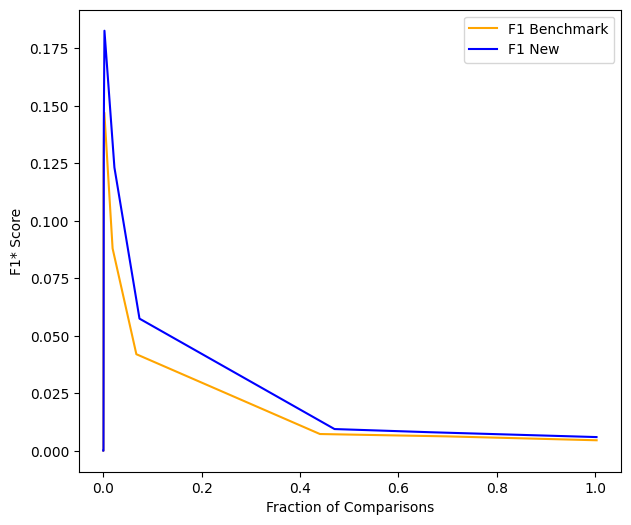

In [9]:
import matplotlib.pyplot as plt

# Provided data
data_old = F1_testing_scores_old
data_new = F1_testing_scores_new

def process_data(data):
    averaged_data = {}
    for i, b_data in data.items():
        for b, values in b_data.items():
            if b not in averaged_data:
                averaged_data[b] = {'total_F1': 0, 'total_fraction': 0, 'count': 0}
            averaged_data[b]['total_F1'] += values['F1']
            averaged_data[b]['total_fraction'] += values['fraction_of_comparisons']
            averaged_data[b]['count'] += 1

    for b, values in averaged_data.items():
        count = values['count']
        averaged_data[b]['average_F1'] = values['total_F1'] / count
        averaged_data[b]['average_fraction'] = values['total_fraction'] / count

    averaged_fractions = [values['average_fraction'] for values in averaged_data.values()]
    averaged_F1_scores = [values['average_F1'] for values in averaged_data.values()]

    return averaged_fractions, averaged_F1_scores

averaged_fractions, averaged_F1_scores = process_data(data_old)
averaged_fractions_2, averaged_F1_scores_2 = process_data(data_new)

# Plotting the averaged data
plt.figure(figsize=(7, 6))
plt.plot(averaged_fractions, averaged_F1_scores_2, color='orange', label='F1 Benchmark')
plt.plot(averaged_fractions_2, averaged_F1_scores, color='blue', label='F1 New')
plt.xlabel('Fraction of Comparisons')
plt.ylabel('F1* Score')
plt.legend()
plt.show()